In [1]:
%matplotlib inline
# We'll start with our library imports...
from __future__ import print_function

import matplotlib.pyplot as plt  # to visualize data and draw plots
import numpy as np  # to use numpy arrays
import tensorflow as tf  # to specify and run computation graphs
from tqdm import tqdm  # to track progress of loops
import tensorflow_datasets as tfds  # to load training data
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
import math  # For mathematical operations


DATA_DIR = "./tensorflow-datasets/"
# Load the Oxford-IIIT Pet Dataset
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

train_ds = tfds.load(
    "oxford_iiit_pet:3.*.*",
    split='train[:80%]',
    data_dir=DATA_DIR
)
val_ds = tfds.load(
    "oxford_iiit_pet:3.*.*",
    split='train[80%:]',
    data_dir=DATA_DIR
)
test_ds = tfds.load(
    "oxford_iiit_pet:3.*.*",
    split='test',
    data_dir=DATA_DIR
)

2024-12-06 17:25:11.915507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 17:25:13.095389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


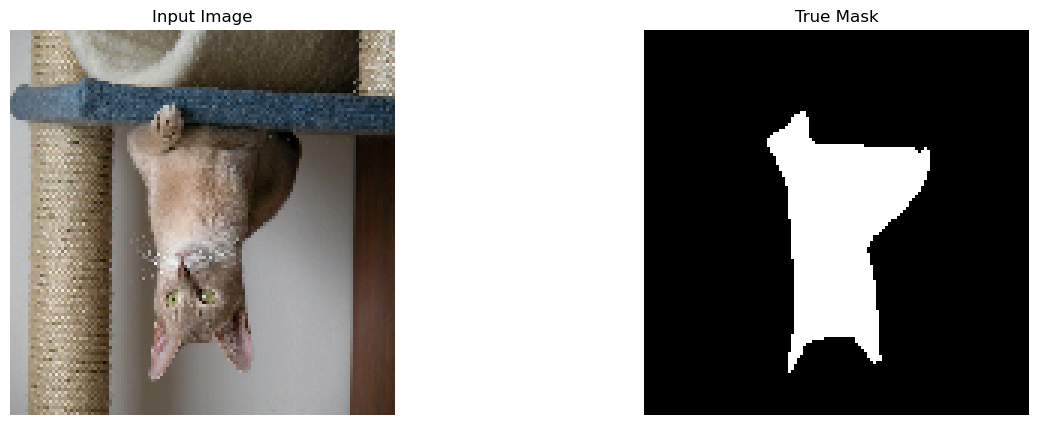

2024-12-06 17:30:11.390179: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/150


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


368/368 [==============================] - 18s 45ms/step - loss: 0.5350 - accuracy: 0.7343 - val_loss: 0.4588 - val_accuracy: 0.7740
Epoch 2/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4614 - accuracy: 0.7846 - val_loss: 0.4434 - val_accuracy: 0.7941
Epoch 3/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4564 - accuracy: 0.7884 - val_loss: 0.4451 - val_accuracy: 0.7955
Epoch 4/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4499 - accuracy: 0.7915 - val_loss: 0.4321 - val_accuracy: 0.8055
Epoch 5/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4472 - accuracy: 0.7947 - val_loss: 0.4379 - val_accuracy: 0.7987
Epoch 6/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4352 - accuracy: 0.8002 - val_loss: 0.4135 - val_accuracy: 0.8102
Epoch 7/150
368/368 [==============================] - 17s 45ms/step - loss: 0.4315 - accuracy: 0.8039 - val_loss: 0.4054 - val_accuracy: 0.81

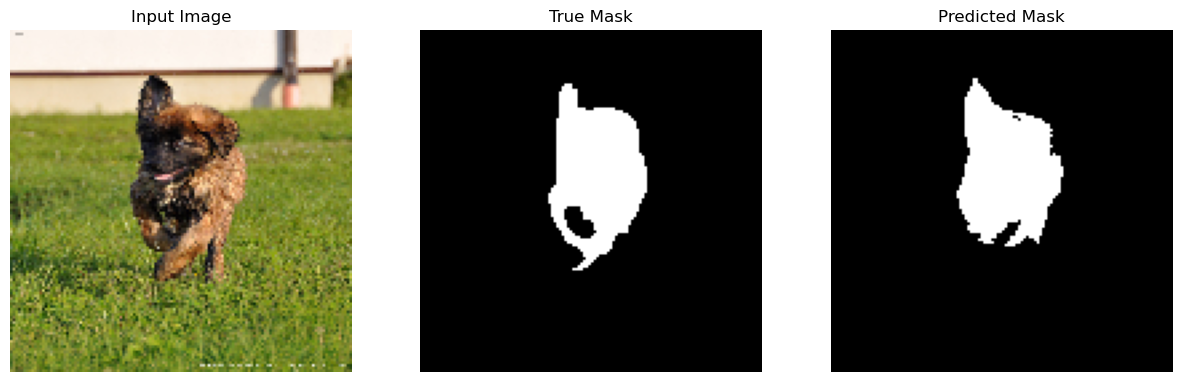

Sample Index: 806
Unique values in the true mask: [0. 1.]
Unique values in the predicted mask: [0. 1.]
------------------------------


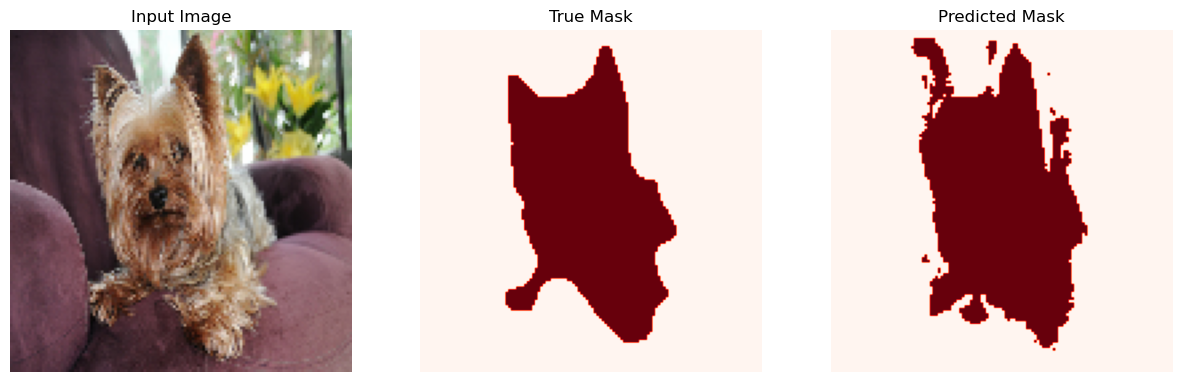

Sample Index: 2391
Unique values in the true mask: [0. 1.]
Unique values in the predicted mask: [0. 1.]
------------------------------


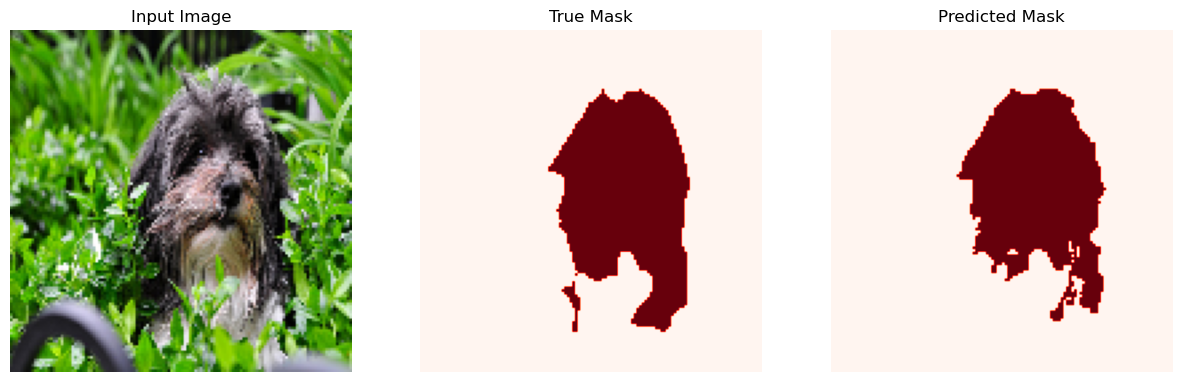

Sample Index: 2863
Unique values in the true mask: [0. 1.]
Unique values in the predicted mask: [0. 1.]
------------------------------


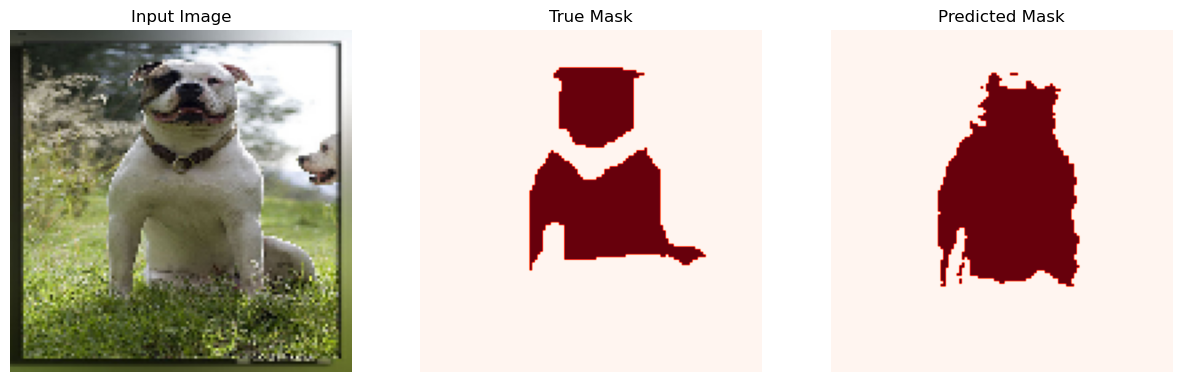

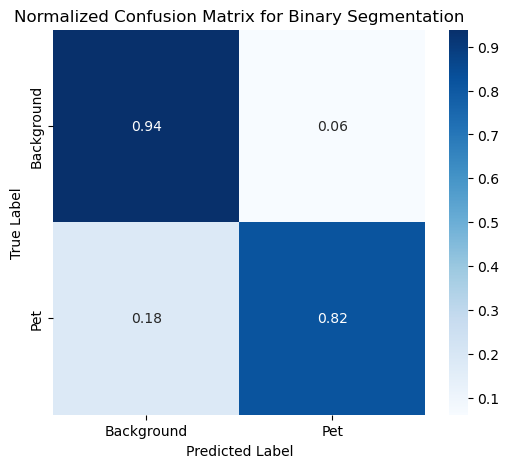

    Sample Index Unique Values in True Mask Unique Values in Predicted Mask
0              1                 [0.0, 1.0]                      [0.0, 1.0]
1              1                 [0.0, 1.0]                      [0.0, 1.0]
2              1                 [0.0, 1.0]                      [0.0, 1.0]
3              1                 [0.0, 1.0]                      [0.0, 1.0]
4              1                 [0.0, 1.0]                      [0.0, 1.0]
5              1                 [0.0, 1.0]                      [0.0, 1.0]
6              1                 [0.0, 1.0]                      [0.0, 1.0]
7              1                 [0.0, 1.0]                      [0.0, 1.0]
8              2                 [0.0, 1.0]                      [0.0, 1.0]
9              2                 [0.0, 1.0]                      [0.0, 1.0]
10             2                 [0.0, 1.0]                      [0.0, 1.0]
11             2                 [0.0, 1.0]                      [0.0, 1.0]
12          

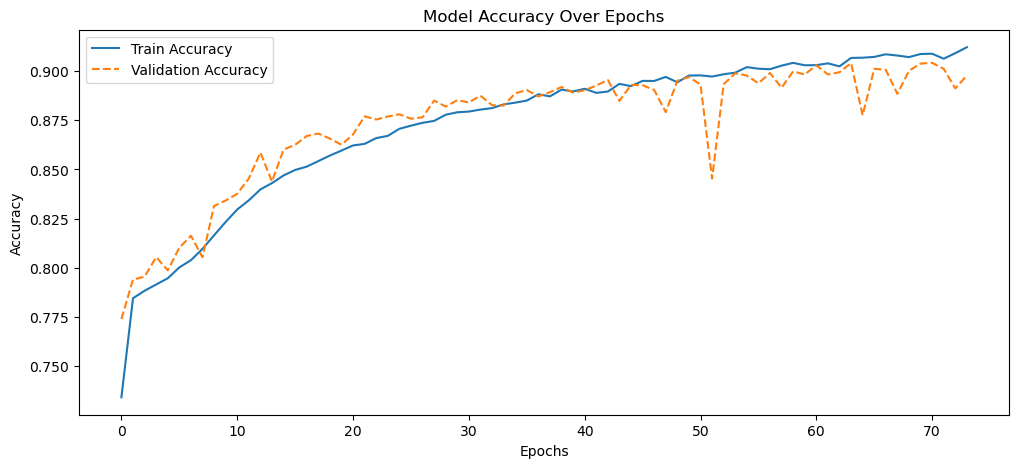

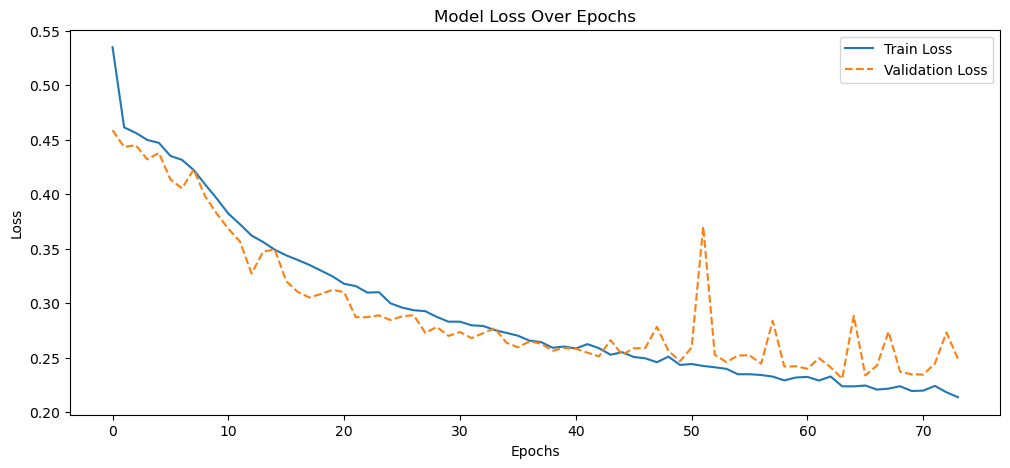

Test complete


In [3]:
# Define image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 8   # Adjust as needed based on your computational resources
BUFFER_SIZE = 1000


def augment(image, mask):

    # Random flip left-right
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random flip up-down
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random brightness
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_brightness(
            image, delta=tf.random.uniform([], -0.1, 0.1))

    # Random contrast
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_contrast(
            image, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    # Random saturation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_saturation(
            image, saturation_factor=tf.random.uniform([], 0.9, 1.1))

    # Random hue
    if tf.random.uniform(()) > 0.5:
        image = tf.image.adjust_hue(
            image, delta=tf.random.uniform([], -0.1, 0.1))

    # Random 90-degree rotation
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)

    return image, mask

def tfa_image_rotate(image, angle, interpolation='BILINEAR'):
    """
    Rotate an image by a given angle.

    Args:
        image: A 3D tensor of shape [height, width, channels].
        angle: Rotation angle in radians.
        interpolation: Interpolation method. Either 'NEAREST' or 'BILINEAR'.

    Returns:
        Rotated image.
    """
    image_shape = tf.shape(image)
    height = image_shape[0]
    width = image_shape[1]

    # Cast width and height to float32
    width = tf.cast(width, tf.float32)
    height = tf.cast(height, tf.float32)

    # Rotation matrix components
    cos_val = tf.cos(angle)
    sin_val = tf.sin(angle)

    # Construct the rotation matrix
    rotation_matrix = tf.reshape(
        [cos_val, -sin_val, 0.0,
         sin_val, cos_val, 0.0,
         0.0, 0.0],
        [8]
    )

    # Compute the translation to center the rotation
    x_offset = (width - 1.0) / 2.0
    y_offset = (height - 1.0) / 2.0

    # Adjust the transformation matrix to rotate around the center of the image
    translation_matrix = tf.reshape(
        [1.0, 0.0, -x_offset,
         0.0, 1.0, -y_offset,
         0.0, 0.0],
        [8]
    )

    # Combine rotation and translation matrices
    transform_matrix = tf.raw_ops.AddV2(
        x=rotation_matrix,
        y=translation_matrix
    )

    # Adjust for the offset after rotation
    transform_matrix = tf.raw_ops.AddV2(
        x=transform_matrix,
        y=[0.0, 0.0, x_offset, 0.0, 0.0, y_offset, 0.0, 0.0]
    )

    # Apply the transformation
    transformed_image = tf.image.transform(
        images=image,
        transforms=transform_matrix,
        interpolation=interpolation
    )

    return transformed_image



def normalize(input_image, input_mask):
    """
    Normalize the input images and masks, and binarize the masks to segment the pet.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # Adjust mask labels to start from 0
    input_mask = tf.cast(input_mask, tf.int32) - 1  # Now labels are 0 (pet), 1 (background), 2 (outline)
    # Binarize the mask: pet pixels (label 0) become 1, else 0
    input_mask = tf.where(input_mask == 0, 1, 0)
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask

def load_image(datapoint):
    """
    Resize and normalize images and masks from the dataset.
    """
    # Extract image and mask from the datapoint
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    
    # Resize images
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    
    # Normalize images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


# Preprocess the datasets
train_dataset = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation to the training dataset
train_dataset = train_dataset.cache()
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Batch the validation and test datasets
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


# Visualize augmented images
for image_batch, mask_batch in train_dataset.take(1):
    sample_image, sample_mask = image_batch[0], mask_batch[0]
    display([sample_image, sample_mask])


def unet_model(output_channels):
    """
    Build a U-Net model for semantic segmentation.
    """
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder (Downsampling path)
    c1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    c5 = tf.keras.layers.Conv2D(1024, 3, activation="relu", padding="same")(c5)

    # Decoder (Upsampling path)
    u6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding="same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(u6)
    c6 = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(u7)
    c7 = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(u8)
    c8 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(u9)
    c9 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(c9)

    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation="sigmoid")(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model
OUTPUT_CHANNELS = 1  # Binary segmentation (pet vs. background)
model = unet_model(OUTPUT_CHANNELS)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Calculate steps per epoch
TOTAL_TRAIN_IMAGES = info.splits['train'].num_examples
TRAIN_LENGTH = int(TOTAL_TRAIN_IMAGES * 0.8)  # Since we use 80% of the train split
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = (TOTAL_TRAIN_IMAGES - TRAIN_LENGTH) // BATCH_SIZE

# Train the model
EPOCHS = 150  # Adjust as needed based on your computational resources
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping]
)



# Evaluate the model on the test dataset
model.evaluate(test_dataset)

def display(display_list):
    plt.figure(figsize=(15, 5))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(tf.squeeze(display_list[i]), cmap='gray', vmin=0, vmax=1)
        plt.axis("off")
    plt.show()

# Visualize predictions
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
    sample_image_exp = tf.expand_dims(sample_image, axis=0)
    pred_mask = model.predict(sample_image_exp)
    pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

    # Diagnostic prints
    print("Unique values in the true mask:", np.unique(sample_mask.numpy()))
    print("Unique values in the predicted mask:", np.unique(pred_mask[0]))

    display([sample_image, sample_mask, pred_mask[0]])

def display_random_samples(test_dataset, model, num_samples=3):
    """
    Display a specified number of random samples from the test dataset along with their true and predicted masks.

    Args:
        test_dataset (tf.data.Dataset): The test dataset.
        model (tf.keras.Model): The trained segmentation model.
        num_samples (int): Number of random samples to display.
    """
    # Convert the test_dataset to a list for easier random access
    test_images = []
    test_masks = []

    for image_batch, mask_batch in test_dataset:
        for img, msk in zip(image_batch, mask_batch):
            test_images.append(img)
            test_masks.append(msk)

    total_test_images = len(test_images)

    if total_test_images == 0:
        print("No images found in the test dataset.")
        return

    # Randomly select indices
    random_indices = random.sample(range(total_test_images), min(num_samples, total_test_images))

    for idx in random_indices:
        sample_image = test_images[idx]
        sample_mask = test_masks[idx]

        # Expand dimensions to match model input
        sample_image_exp = tf.expand_dims(sample_image, axis=0)

        # Predict the mask
        pred_mask = model.predict(sample_image_exp)[0]
        pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

        # Diagnostic prints
        print(f"Sample Index: {idx}")
        print("Unique values in the true mask:", np.unique(sample_mask.numpy()))
        print("Unique values in the predicted mask:", np.unique(pred_mask.numpy()))
        print("-" * 30)

        # Display the results
        plt.figure(figsize=(15, 5))

        titles = ["Input Image", "True Mask", "Predicted Mask"]
        images = [sample_image, sample_mask, pred_mask]

        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(titles[i])
            if i == 0:
                plt.imshow(images[i])
            else:
                plt.imshow(tf.squeeze(images[i]), cmap='Reds', vmin=0, vmax=1)
            plt.axis("off")

        plt.show()

# Visualize a random set of 3 images
display_random_samples(test_dataset, model, num_samples=3)

def calculate_confusion_matrix(test_dataset, model):
    all_true_labels = []
    all_pred_labels = []

    # Loop through test data
    for images, masks in test_dataset:
        preds = model.predict(images)
        preds = tf.where(preds > 0.5, 1.0, 0.0)  # Binarize predictions

        for true_mask, pred_mask in zip(masks, preds):
            true_labels = tf.reshape(true_mask, [-1])  # Flatten mask
            pred_labels = tf.reshape(pred_mask, [-1])  # Flatten prediction

            all_true_labels.extend(true_labels.numpy())
            all_pred_labels.extend(pred_labels.numpy())

    # Compute confusion matrix and normalize
    cm = confusion_matrix(all_true_labels, all_pred_labels, labels=[0, 1])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['Background', 'Pet'], yticklabels=['Background', 'Pet'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Normalized Confusion Matrix for Binary Segmentation")
    plt.show()

# Call the function
calculate_confusion_matrix(test_dataset, model)

def display_random_samples_table(test_dataset, model, num_samples=5):
    samples = []
    for i, (image_batch, mask_batch) in enumerate(test_dataset.take(num_samples)):
        for image, mask in zip(image_batch, mask_batch):
            sample_image_exp = tf.expand_dims(image, axis=0)
            pred_mask = model.predict(sample_image_exp)
            pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)  # Binarize predicted mask

            true_mask_unique = np.unique(mask.numpy())
            pred_mask_unique = np.unique(pred_mask[0])

            samples.append({
                "Sample Index": i + 1,
                "Unique Values in True Mask": true_mask_unique,
                "Unique Values in Predicted Mask": pred_mask_unique
            })

    # Convert samples to a DataFrame for a clear tabular format
    df_samples = pd.DataFrame(samples)
    print(df_samples)

# Call the function to display random samples table
display_random_samples_table(test_dataset, model, num_samples=3)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

print("Test complete")